# JAX Implementation of PINN solution of the Viscous Burgers PDE

Scientific Machine Learning Workshop at Cenpes 2025<br>
This code is distributed under the GNU LGPL license.<br>
Last Modified: Aug 2025<br>

Simple JAX implementation of<br>
PINN solution of Burgers PDE with sinusoidal IC<br>
Uses elements of the code in [1].

Author: Ulisses Braga-Neto <br>
Department of Electrical and Computer Engineering<br>
Texas A&M University<br>

This code demonstrates coding and training a physically-informed neural networks (PINN) to solve  the viscous Burgers nonlinear PDE with a sinusoidal initial condition and homogeneous Dirichlet boundary conditions:

  \begin{aligned}
  &u_t + uu_x = \nu u_{xx}\,, \quad (x,t) \in [-1,1] \times [0,\infty)\,,\\
    & u(x,0) = -\sin(\pi x)\,, \quad -1 < x < 1\,, \\
    &u(1,t) = u(-1,t) = 0\,, \quad t>0\,,\quad\quad\quad\quad\quad\quad (1)\\
  \end{aligned}

where $\nu>0$ is the kinematic viscosity. If $\nu =0$, this is the inviscid Burgers equation. If $\nu$ is smaller than about $0.1\pi$, the solution of (1) has a hyperbolic character, and a "shock" forms at $x=0$.

The PINN solution is compared to an accurate Gauss-Hermite quadrature of the Cole-Hopf formula for the exact solution.
The quadrature approximation is based on the fact that, for small enough $\nu$, the viscous Burgers PDE becomes an approximation of the inviscid Burgers problem, in which case it can be proved using the method of characteristics that any zero value in the initial condition stays constant at zero throughout the solution. Therefore, (1) is approximately equal to the initial-value problem (IVP):
\begin{aligned}
  &\hat{u}_t + \hat{u}\hat{u}_x = \nu \hat{u}_{xx}\,, \quad (x,t) \in R \times [0,\infty)\,,\\
    & \hat{u}(x,0) = \begin{cases} -\sin(\pi x)\,,& -1 < x < 1\,,\\
    0\,, & |x|>1\,. \end{cases} \quad\quad\quad\quad  (2)\\
  \end{aligned}
The Cole-Hopf transform [2] provides a closed-form solution to the IVP (2):

$$\hat{u}(x,t) = -\frac{\int_{-\infty}^\infty \sin(\pi(x-z))\exp\left(-\frac{\cos(\pi(x-z))}{2\pi \nu}\right)\exp\left(-\frac{z^2}{4\nu t}\right)\, dz}
{\int_{-\infty}^\infty \exp\left(-\frac{\cos(\pi(x-z))}{2\pi \nu}\right)\exp\left(-\frac{z^2}{4\nu t}\right)\, dz}\,.$$

For sufficiently small $t$, we have $u(x,t) \approx \hat{u}(x,t)$, for $x \in [-1,1]$. In [3], it is claimed that Gauss-Hermite quadrature produced a seven-digit accurate result for $u_x(0,t)$ up to $t = 3/\pi$ with a viscosity $\nu = 0.01/\pi$.

References:

[1] https://github.com/ASEM000/Physics-informed-neural-network-in-JAX

[2]  E. Hopf, The partial differential equation $u_t + uu_x = \mu u_{xx}$. Comm. Pure Appl. Math. 3, 201-230, 1950.

[3] Claude Basdevant, Michel Deville, Pierre Haldenwang, J Lacroix,
  J Ouazzani, Roger Peyret, Paolo Orlandi, Anthony Patera,
  Spectral and finite difference solutions of the Burgers equation,
  Computers and Fluids,   Volume 14, Number 1, 1986, pages 23-41.

In [1]:
# import necessary libraries

import jax
import jax.numpy as jnp
import numpy as np
import scipy.io
import math
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import optax
from scipy.stats.qmc import LatinHypercube as lhs

In [44]:
"""
Problem Definition and Quadrature Solution
"""

from numpy.polynomial.hermite import hermgauss

nu = 0.01/np.pi # viscosity parameter

# define grid for quadrature solution
utn = 128
uxn = 256
xlo = -1.0
xhi = +1.0
ux = np.linspace(xlo,xhi,uxn)
tlo = 0.0
thi = 5.0/np.pi
ut = np.linspace(tlo,thi,utn)

qn = 64 # order of quadrature rule
qx,qw = hermgauss(qn)

# compute solution u(x,t) by quadrature of analytical formula:
u_quad = np.zeros([uxn,utn])
for utj in range(utn):
  if (ut[utj]==0.0):
    for uxj in range(uxn):
      u_quad[uxj,utj] = -np.sin(np.pi*ux[uxj])
  else:
    for uxj in range(uxn):
      top = 0.0
      bot = 0.0
      for qj in range(qn):
        c = 2.0*np.sqrt(nu*ut[utj])
        top = top-qw[qj]*c*np.sin(np.pi*(ux[uxj]-c*qx[qj]))*np.exp(-np.cos(np.pi*(ux[uxj]-c*qx[qj]))/(2.0*np.pi*nu))
        bot = bot+qw[qj]*c*np.exp(-np.cos(np.pi*(ux[uxj]-c*qx[qj]))/(2.0*np.pi*nu))
        u_quad[uxj,utj] = top/bot

# flatten grid and solution
X,T = np.meshgrid(ux,ut)
X_flat = X.flatten()[:,None]
T_flat = T.flatten()[:,None]
u_flat = u_quad.T.flatten()

In [45]:
# solution neural network

def PINN(x,t,params):
  X = jnp.concatenate([x,t],axis=1)
  *hidden,last = params
  for layer in hidden :
    X = jax.nn.tanh(X@layer['W']+layer['B'])
  return X@last['W'] + last['B']

In [46]:
# residual neural network

def r_PINN(u,x,t):
  u_x  = lambda x,t:jax.grad(lambda x,t:jnp.sum(u(x,t)),0)(x,t)
  u_xx = lambda x,t:jax.grad(lambda x,t:jnp.sum(u_x(x,t)),0)(x,t)
  u_t  = lambda x,t:jax.grad(lambda x,t:jnp.sum(u(x,t)),1)(x,t)
  return u_t(x,t) + u(x,t)*u_x(x,t) - nu*u_xx(x,t)

In [47]:
# weight initialization

def init_params(layer_sizes):
  keys = jax.random.split(jax.random.PRNGKey(0),len(layer_sizes)-1)
  params = list()
  for key,n_in,n_out in zip(keys,layer_sizes[:-1],layer_sizes[1:]):
    lb,ub = -(1/jnp.sqrt(n_in)),(1/jnp.sqrt(n_in)) # xavier initialization lower and upper bound
    W = lb + (ub-lb) * jax.random.uniform(key,shape=(n_in,n_out))
    B = jax.random.uniform(key,shape=(n_out,))
    params.append({'W':W,'B':B})
  return params

In [48]:
# loss function

@jax.jit
def MSE(true,pred):
  return jnp.mean((true-pred)**2)

def loss(params,xcl,tcl,x0,t0,u0,xlb,tlb,ulb,xub,tub,uub):

    u0_pred  = PINN(x0,t0,params)
    ulb_pred = PINN(xlb,tlb,params)
    uub_pred = PINN(xub,tub,params)

    ufunc = lambda x,t:PINN(x,t,params)
    r_pred = r_PINN(ufunc,xcl,tcl)

    # loss components
    mse_0  = MSE(u0,u0_pred)
    mse_lb = MSE(ulb,ulb_pred)
    mse_ub = MSE(uub,uub_pred)
    mse_r  = MSE(r_pred,0)

    return  mse_0+mse_lb+mse_ub+mse_r

In [49]:
# neural network weight gradients and update

@jax.jit
def grad_update(opt_state,params,xcl,tcl,x0,t0,u0,xlb,tlb,ulb,xub,tub,uub):

  # Get the gradient w.r.t to MLP params
  grads=jax.jit(jax.grad(loss,0))(params,xcl,tcl,x0,t0,u0,xlb,tlb,ulb,xub,tub,uub)

  #Update params
  updates,opt_state = optimizer.update(grads,opt_state)
  params = optax.apply_updates(params,updates)

  #Update params
  return opt_state,params

In [50]:
# collocation points
Ncl = 10000
X = lhs(2).random(Ncl)
xcl = xlo+(xhi-xlo)*X[:,0].reshape(-1,1)
tcl = tlo+(thi-tlo)*X[:,1].reshape(-1,1)

# initial condition points
N0 = 200
X = lhs(2).random(N0)
x0 = xlo+(xhi-xlo)*X[:,0].reshape(-1,1)
t0 = jnp.zeros([N0,1])
u0 = -jnp.sin(jnp.pi*x0)

# Dirichlet boundary condition points
Nb = 100
X = lhs(2).random(Nb)
tlb = tlo+(thi-tlo)*X[:,0].reshape(-1,1)
xlb = xlo*jnp.ones_like(tlb)
ulb = jnp.zeros_like(tlb)
#X = lhs(1,Nb)
tub = tlb #tlo+(thi-tlo)*X[:,0]
xub = xhi*jnp.ones_like(tub)
uub = jnp.zeros_like(tub)

iter =  200
loss = 0.0463
L2 error: 2.4073e-01


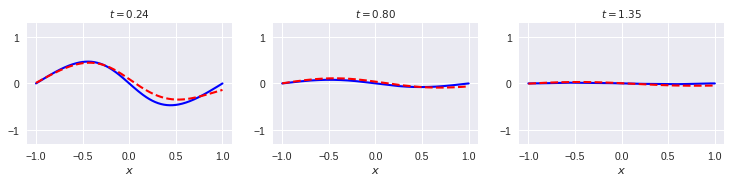

iter =  400
loss = 0.0073
L2 error: 1.4586e-01


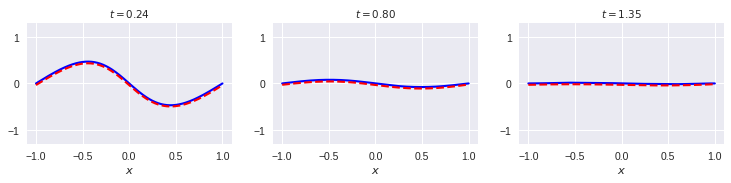

iter =  600
loss = 0.0021
L2 error: 2.4514e-02


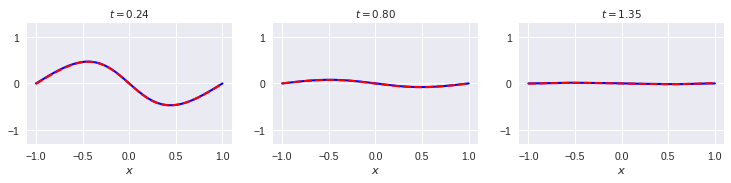

iter =  800
loss = 0.0011
L2 error: 1.7802e-02


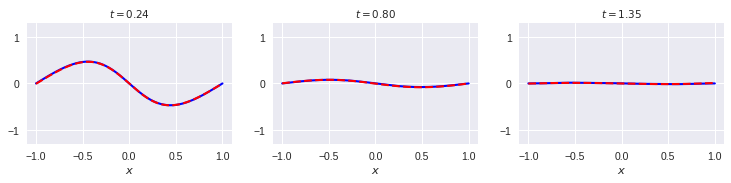

iter =  1000
loss = 0.0007
L2 error: 1.6627e-02


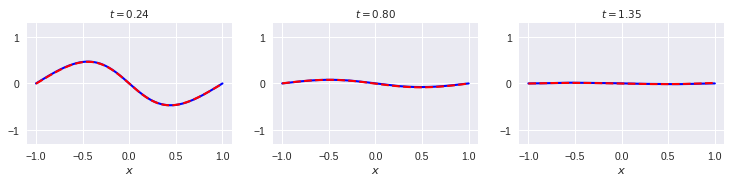

iter =  1200
loss = 0.0005
L2 error: 1.6004e-02


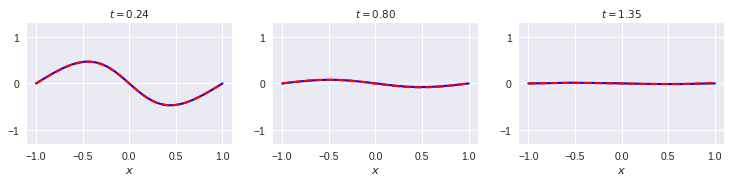

iter =  1400
loss = 0.0004
L2 error: 1.4805e-02


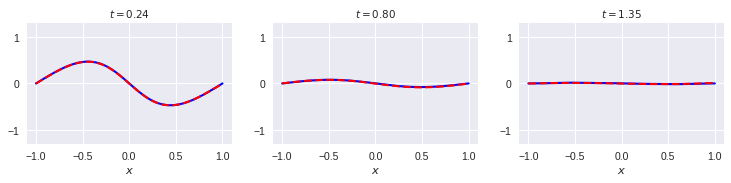

iter =  1600
loss = 0.0019
L2 error: 1.0994e-01


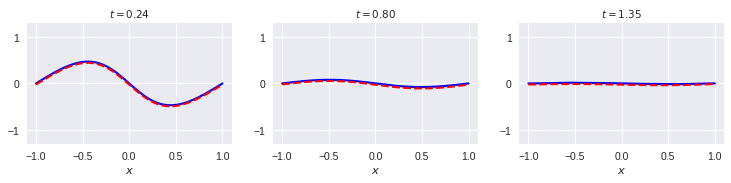

iter =  1800
loss = 0.0003
L2 error: 1.3666e-02


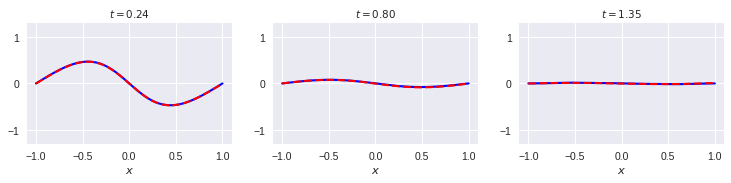

iter =  2000
loss = 0.0003
L2 error: 1.6808e-02


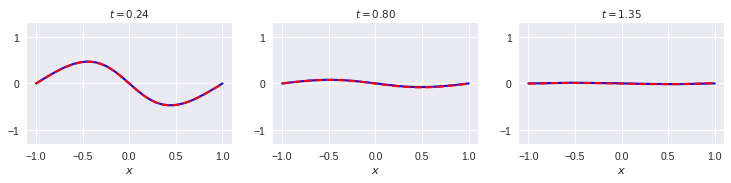

iter =  2200
loss = 0.0003
L2 error: 1.2382e-02


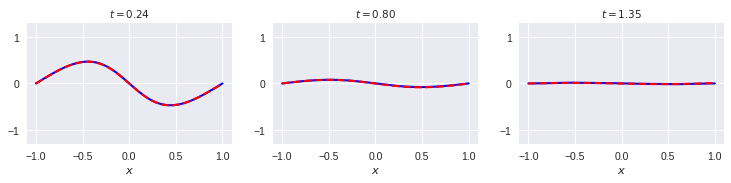

iter =  2400
loss = 0.0027
L2 error: 1.3006e-01


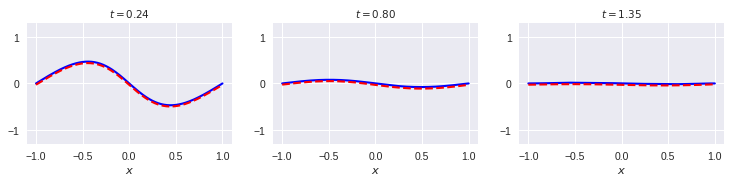

KeyboardInterrupt: 

In [51]:
# training loop

# initialize new instance of NN
layer_sizes = [2] + 8*[20] + [1]
params = init_params(layer_sizes)

# Adam optimizer
lr = optax.constant_schedule(1e-3)
optimizer = optax.adam(lr)
opt_state = optimizer.init(params)

for iter in range(5000):

  opt_state,params = grad_update(opt_state,params,xcl,tcl,x0,t0,u0,xlb,tlb,ulb,xub,tub,uub)

  # display intermediate results
  if ((iter+1) % 200 == 0):
    print('iter =  '+str(iter+1))
    print('loss = {:.4f}'.format(loss(params,xcl,tcl,x0,t0,u0,xlb,tlb,ulb,xub,tub,uub)))

    u_PINN_flat = PINN(X_flat,T_flat,params)
    err = jnp.linalg.norm(u_flat-u_PINN_flat[:,-1],2)/jnp.linalg.norm(u_flat,2)
    print('L2 error: %.4e' % (err))
    #plot_slices(u_flat,u_PINN_flat,[0.15,0.5,0.85])
    fig = plt.figure(figsize=(12,4),dpi=75)
    plt.style.use('seaborn-v0_8')
    for gi,snap in enumerate([0.15,0.5,0.85]):
      tind = int(snap*len(ut))
      ax = fig.add_subplot(1,3,gi+1)
      ax.set_aspect(0.5)
      ax.plot(ux,u_flat[tind*uxn:(tind+1)*uxn],'b-',linewidth=2,label='Exact')
      ax.plot(ux,u_PINN_flat[tind*uxn:(tind+1)*uxn,0],'r--',linewidth=2,label='Prediction')
      ax.set_title('$t = %.2f$' % (ut[tind]),fontsize=10)
      ax.set_xlabel('$x$')
      ax.set_ylim([-1.3,1.3])
    plt.show()

<ipython-input-12-685f2dc9a9bf>:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['-1.0','-0.6','-0.2','0.2','0.6','1.0'])
<ipython-input-12-685f2dc9a9bf>:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['-1.0','-0.6','-0.2','0.2','0.6','1.0'])


Text(0.5, 1.0, 'PINN Prediction (L2 error = 0.0924)')

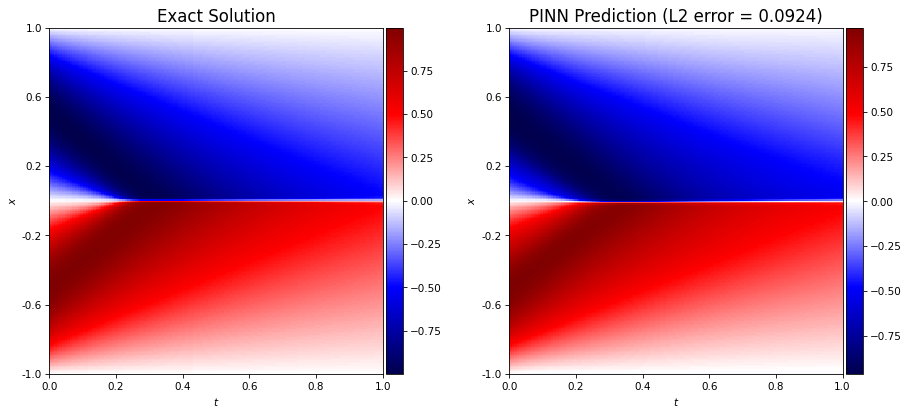

In [ ]:
#Display results

fig = plt.figure(figsize=(14,6),dpi=75)
fig.subplots_adjust(wspace=0.3)
plt.style.use('default')
ax = fig.add_subplot(121)
ax.set_aspect(1)
im=ax.imshow(np.reshape(u_flat,(utn,uxn)).T,interpolation='nearest',cmap='seismic',extent=[0.0,1.0,0.0,1.0],origin='lower',aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im,cax=cax)
ax.set_yticklabels(['-1.0','-0.6','-0.2','0.2','0.6','1.0'])
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title('Exact Solution',fontsize=16)

ax = fig.add_subplot(122)
ax.set_aspect(1)
im=ax.imshow(np.reshape(u_PINN_flat,(utn,uxn)).T,interpolation='nearest',cmap='seismic',extent=[0.0,1.0,0.0,1.0],origin='lower',aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im,cax=cax)
ax.set_yticklabels(['-1.0','-0.6','-0.2','0.2','0.6','1.0'])
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title('PINN Prediction (L2 error = {:.4f})'.format(err),fontsize=16)